In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

# sub class from modelling_bert "RobertaForSequenceClassification" and override the forward method
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
repo_link_nli = "cross-encoder/nli-distilroberta-base"

model_args = {
    "model_name": repo_link_nli,
}

tokenizer_nli = AutoTokenizer.from_pretrained(repo_link_nli)
model_nli = AutoModelForSequenceClassification.from_pretrained(repo_link_nli, output_hidden_states=True).to(device)

In [9]:
import numpy as np
import re

PUNCT = '!"#$%&\'()*+,-./:;<=>?@\\^_`|~'

punct_regex = re.compile(r"([%s])" % PUNCT)

def split_punctuation(toks):
    aux_toks = []
    for tok in toks:
        split_toks = re.split(punct_regex, tok)
        aux_toks += [tok for tok in split_toks if tok != ""]
    return aux_toks

def custom_tokenization_granular(text, sep_marker, word_set):
    text = text.split(" ")
    text = split_punctuation(text)
    tok_list = []
    for tok in text:
        if tok not in word_set:
            tok_list += [tok]
        else:
            tok_list += [tok[0]]
            for chr in tok[1:]:
                tok_list += [f"{sep_marker}{chr}"]

    return tok_list

def custom_tokenization(premise_hypothesis, tokenizer: AutoTokenizer, word_set) -> dict:
    sep_token = tokenizer.sep_token
    pad_tok_id = tokenizer.pad_token_id

    # bos and eos tokens are added by tokenizer.encode() [AT LEAST FOR DISTILBERTA BASE]
    premise_tokens = custom_tokenization_granular(premise_hypothesis[0].lower(), "", word_set)
    hypothesis_tokens = custom_tokenization_granular(premise_hypothesis[1].lower(), "", word_set)
    input_tokens = " ".join(premise_tokens + [sep_token] + hypothesis_tokens)

    token_ids = tokenizer.encode(input_tokens)
    # print(token_ids)
    # print(decode_tokens(token_ids, tokenizer))
    attention_mask = [int(tok_id != pad_tok_id )for tok_id in token_ids]
    unk_tok_num = sum([tok_id == tokenizer.unk_token_id for tok_id in token_ids])
    assert not(unk_tok_num > 0), f"There are unknown tokens in the text! {unk_tok_num} unknown tokens."

    output = {
        "input_ids": None,
        "attention_mask": None # always 1 except for padding tokens
    }

    # input_ids on cuda
    # attention mask on cuda

    output["input_ids"] = torch.as_tensor([token_ids], device=device)
    output["attention_mask"] = torch.as_tensor([attention_mask], device=device)

    return output

def decode_tokens(toks, tokenizer):
    return "".join([f'{tokenizer.decode(x)}' for x in toks])

def get_prediction(premise_hypothesis, word_set):
    tok_output = custom_tokenization(premise_hypothesis, tokenizer_nli, word_set)
    model_outputs = model_nli(**tok_output)
    probs = torch.softmax(model_outputs.logits, dim=1).tolist()[0]
    output = {
        "label": model_nli.config.id2label[np.argmax(probs)],
        "prob": np.max(probs),
        "all_probs": {model_nli.config.id2label[prob_idx]: prob_aux for prob_idx, prob_aux in zip(np.argsort(probs)[::-1], np.sort(probs)[::-1])}

    }
    return output

test_nli = [
    ("The cat is large. An ant is small.", "The cat is bigger than the ant.", "entailment"),
    ("Dumbo is by the tree and is not small. Bambi is an animal that is not large and is hungry.", "Dumbo is not smaller than Bambi.", "neutral")
    ]

get_prediction(test_nli[0][:2], [])

{'label': 'entailment',
 'prob': 0.6140102744102478,
 'all_probs': {'entailment': 0.6140102744102478,
  'contradiction': 0.19592997431755066,
  'neutral': 0.19005979597568512}}

In [10]:
from collections import defaultdict
from tqdm import tqdm
import itertools

words_test_1 = [
    ["cat", "ant", "small", "large", "bigger", "than", "the", "is", "an"],
    ["Dumbo", "Bambi", "animal", "tree", "small", "large", "smaller", "hungry", "than", "that", "the", "an", "and", "by", "not", "is"]
    ]
words_test_2 = [
    ["the", "an", "is", "bigger", "small", "large", "than", "cat", "ant"],
    ["than", "that", "the", "an", "and", "by", "not", "is", "Dumbo", "Bambi", "animal", "tree", "small", "large", "smaller", "hungry"]
    ]
words_test_3 = [
    ["small", "large", "bigger", "than", "cat", "ant", "the", "an", "is"],
    ["small", "large", "smaller", "hungry", "Dumbo", "Bambi", "animal", "tree", "than", "that", "the", "an", "and", "by", "not", "is"]
    ]

def run_single_experiment(word_test_set, premise_hypothesis_test):
    word_set = set()
    prob_list = defaultdict(list)
    for word in word_test_set:
        word_set |= set([word])
        granular_pred = get_prediction(premise_hypothesis_test, word_set)
        for label, prob in granular_pred["all_probs"].items():
            prob_list[label] += [prob]
        prob_list["pred_label"] += [granular_pred["label"]]

    return prob_list

def generate_run_experiment(premise_hypothesis_test, problem_idx, use_permutations=False):
    if not use_permutations:
        manual_tests = [words_test_1[problem_idx], words_test_2[problem_idx], words_test_3[problem_idx]]
        word_permutations = manual_tests
    else:
        all_words = set(custom_tokenization_granular(premise_hypothesis_test[0] + " " + premise_hypothesis_test[1], "", []))
        itertools.permutations(all_words)

    results = []
    idx = 0
    for test_set in tqdm(word_permutations):
        results += [run_single_experiment(test_set, premise_hypothesis_test)]
        idx += 1
        if idx >= 10:
            break

    return results

results = []
for idx, problem in enumerate(test_nli):
    results += [(generate_run_experiment(problem[:2], idx, use_permutations=False), problem[-1])]

100%|██████████| 3/3 [00:00<00:00, 13.55it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


entailment
neutral


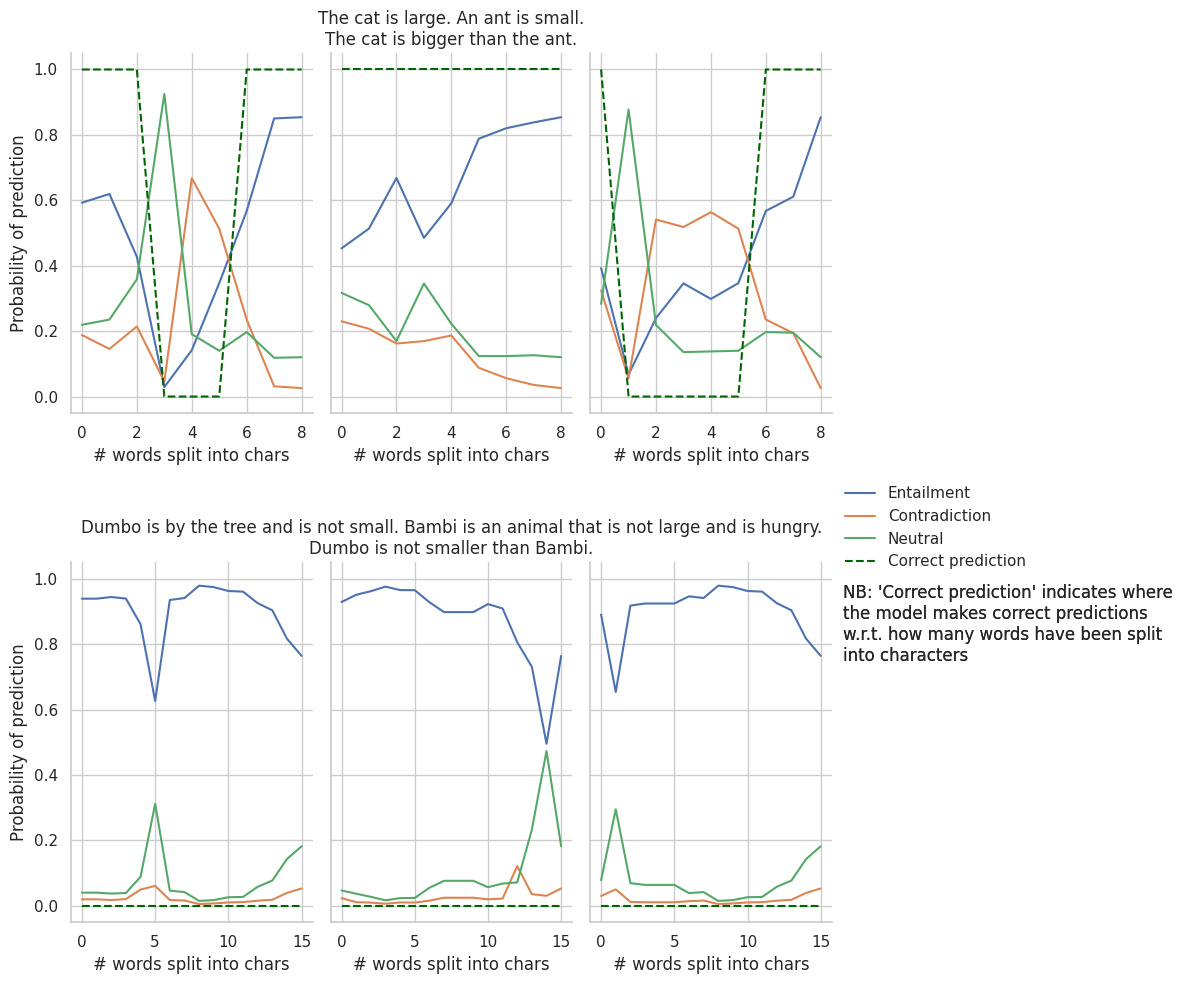

In [11]:
import numpy as np
#### for manual tests
sns.set_theme(style="whitegrid")
fig, axes_all = plt.subplots(2,3,figsize=(12,10), sharey=True)
axes_all_num = np.prod(axes_all.shape)
for prob_results, axes, premises_hypotheses in zip(results, axes_all, test_nli):
    idx = 0
    print(prob_results[1])
    orig_label = prob_results[1]
    for res, ax in zip(prob_results[0], axes):
        idx += 1
        pred_labels = res["pred_label"]
        sns.set_theme(style="whitegrid")
        for label in ["entailment", "contradiction", "neutral"]:
            sns.lineplot(res[label], label=label.title(), ax=ax, legend=True if idx == axes_all_num else False)

        pred_label_comparison = [int(label_aux == orig_label) for label_aux in pred_labels]
        sns.lineplot(pred_label_comparison, label="Correct prediction", linestyle="dashed", color="darkgreen", ax=ax, legend=True if idx == axes_all_num else False)
        sns.despine()
        ax.set_xlabel("# words split into chars")
        ax.set_ylabel("Probability of prediction")
        if idx == 2:
            ax.set_title("\n".join(premises_hypotheses[:2]))
    plt.legend(bbox_to_anchor=(1.86, 1.25), loc="upper right", frameon=False)
    plt.text(s="NB: 'Correct prediction' indicates where\nthe model makes correct predictions\nw.r.t. how many words have been split\ninto characters", x=16.5, y=0.75)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


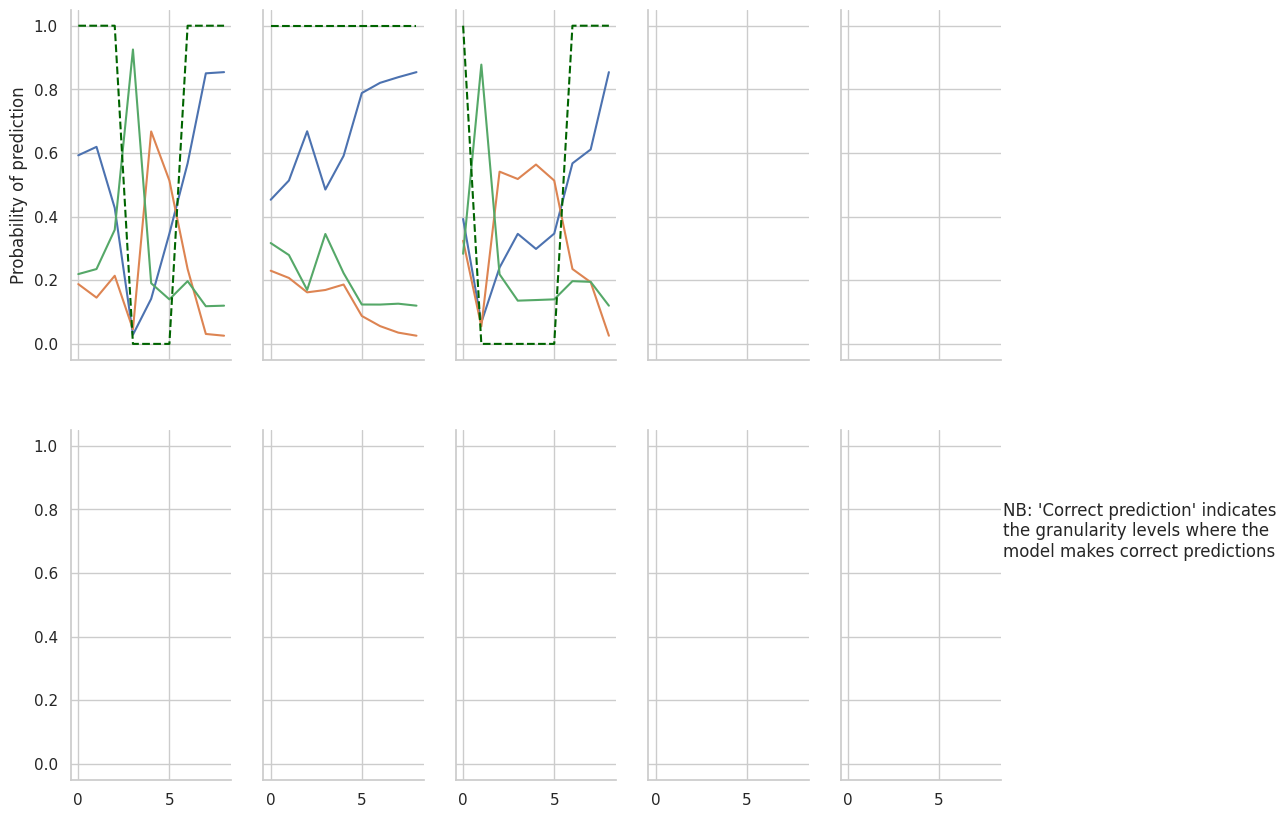

In [8]:
#### for permutation tests
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2,5,figsize=(12,10), sharey=True, sharex=True)
axes = axes.flatten()
idx = 0
orig_label = results[0][1]
for res, ax in zip(results[0][0][:10], axes):
    idx += 1
    pred_labels = res["pred_label"]
    sns.set_theme(style="whitegrid")
    for label in ["entailment", "contradiction", "neutral"]:
        sns.lineplot(res[label], label=label.title(), ax=ax, legend=True if idx == len(axes) else False)

    pred_label_comparison = [int(label_aux == orig_label) for label_aux in pred_labels]
    sns.lineplot(pred_label_comparison, label="Correct prediction", linestyle="dashed", color="darkgreen", ax=ax, legend=True if idx == len(axes) else False)
    sns.despine()
    ax.set_xlabel("Granularity level")
axes[0].set_ylabel("Probability of prediction")
plt.legend(bbox_to_anchor=(1.72, 1), loc="upper right", frameon=False)
plt.text(s="NB: 'Correct prediction' indicates\nthe granularity levels where the\nmodel makes correct predictions", x=8.5, y=0.65)
plt.show()